## Testing the code using the grid system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Creating the grid DF

In [2]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))
values_1 = [1,2,3,4,8,7,6,5,9,10,11,12,16,15,14,13]
values_2 = list(range(1, 17))
df = pd.DataFrame({'FIPS': box_names, 'Value': values,'Value_1': values_1,'Value_2': values_2})

In [3]:
df

,FIPS,Value,Value_1,Value_2
0,A,0,1,1
1,B,1,2,2
2,C,2,3,3
3,D,3,4,4
4,E,4,8,5
5,F,5,7,6
6,G,6,6,7
7,H,7,5,8
8,I,8,9,9
9,J,9,10,10


In [4]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [5]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [6]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [7]:
# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [8]:
gdf

,FIPS,Value,Value_1,Value_2,geometry
0,A,0,1,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,B,1,2,2,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,C,2,3,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,D,3,4,4,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,E,4,8,5,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."
5,F,5,7,6,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
6,G,6,6,7,"POLYGON ((2.000 1.000, 3.000 1.000, 3.000 2.00..."
7,H,7,5,8,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
8,I,8,9,9,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
9,J,9,10,10,"POLYGON ((1.000 2.000, 2.000 2.000, 2.000 3.00..."


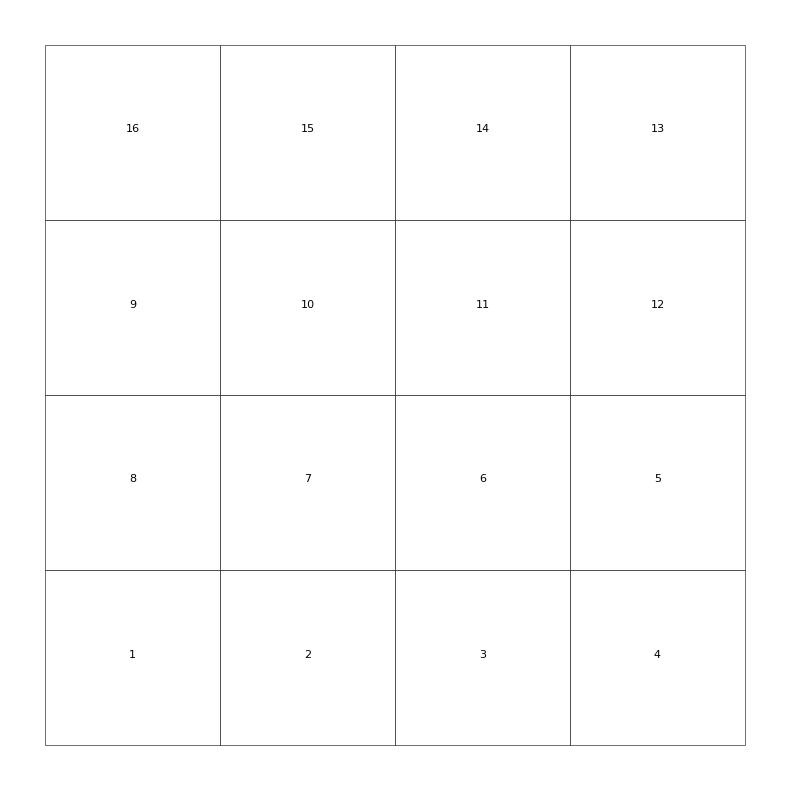

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['Value_1']), fontsize=8, ha='center')

# Display the plot
plt.show()

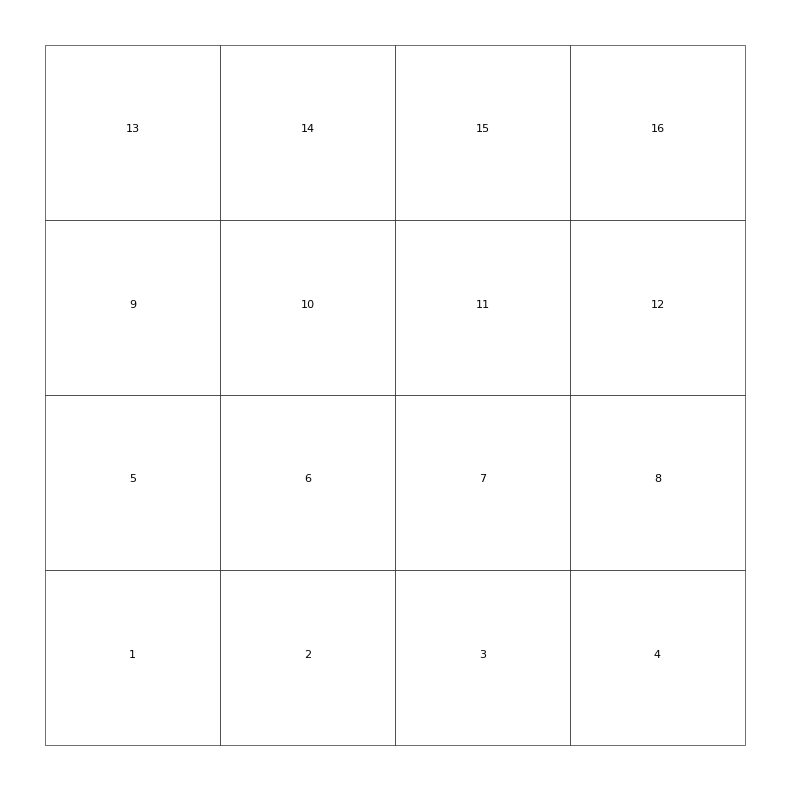

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['Value_2']), fontsize=8, ha='center')

# Display the plot
plt.show()

### Now let's use our code to test

In [ ]:
def fig2img(fig):
     #convert matplot fig to image and return it

     buf = io.BytesIO()
     fig.savefig(buf)
     buf.seek(0)
     img = Image.open(buf)
     return img

In [ ]:
list_gif = []

def test_funf():
    
    filtration_threshold_=16
    selected_edges = []
    
    # Calculate total iterations for tqdm
    total_iterations = int((filtration_threshold_ - 0.0) / 1)
    
    with tqdm(total=total_iterations) as pbar:

        while filtration_threshold_ > 0.0:

            filtered_df = gdf[gdf['Value_2'] > filtration_threshold_]

            # Perform a spatial join to find adjacent precincts
            adjacent_precincts = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

            # Filter the results to include only the adjacent states
            adjacent_precincts = adjacent_precincts.query('FIPS_left != FIPS_right')

            # Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
            adjacent_precincts = adjacent_precincts.groupby('FIPS_left')['FIPS_right'].apply(list).reset_index()

            city_sets = {}

            # iterate through rows and define cities as sets
            for index, row in adjacent_precincts.iterrows():
                city_set_name = row['FIPS_left']
                # print(city_set_name)
                city_set = set(row['FIPS_right'])
                city_sets[city_set_name] = city_set
                # print(city_set)

            #city centroids
            city_coordinates = {city.FIPS: np.array((city.geometry.centroid.x, city.geometry.centroid.y)) for _, city in filtered_df.iterrows()}

            # get all city names from the city sets and insert into an array
            points = [city_set_name for city_set_name in city_sets.keys()]

            # filtered_coordinates = {key: value for key, value in city_coordinates.items() if key in points}

            pairs = []
            for i in range(len(points)):
                        for j in range(i+1, len(points)):
                            pair = [points[i], points[j]]
                            if len(pair) == 2 and pair not in pairs:
                                pairs.append(pair)

            for pair in pairs:
                if pair[0] in city_sets[pair[1]]:

                    if pair not in selected_edges:
                        selected_edges.append(pair)
                        # print("Filteration threshold:",filtration_threshold_)
                        # print("Number of edges:",len(selected_edges))

                        # Create a figure and axis
                        fig, ax = plt.subplots(figsize=(20, 20))
                        ax.set_axis_off() 

                        # Plot the "wyoming_svi" DataFrame
                        gdf.plot(ax=ax, edgecolor='black', linewidth=0.3,color="white")
                        
                        # Plot the centroid of the large square with values
                        for i, row in gdf.iterrows():
                            centroid = row['geometry'].centroid
                            plt.text(centroid.x, centroid.y, str(row['Value_2']), fontsize=15, ha='center',color="black")

                        # Iterate over selected edges and plot them on the same axis
                        for selected_pair in selected_edges:
                            ax.plot([city_coordinates[selected_pair[0]][0], city_coordinates[selected_pair[1]][0]],
                                    [city_coordinates[selected_pair[0]][1], city_coordinates[selected_pair[1]][1]], color='green')


                        # Flatten the list of lists to a single list of edges
                        flat_edges = [edge for sublist in selected_edges for edge in sublist]
                        unique_edges = list(set(flat_edges))

                        filtered_coordinates = {key: value for key, value in city_coordinates.items() if key in unique_edges}
                        # print(filtered_coordinates)
                        # print("Unique centroids",unique_edges)

                        # Color the triangles formed by any three points
                        for combo in combinations(filtered_coordinates.keys(), 3):
                            if combo[1] in city_sets[combo[0]] and combo[2] in city_sets[combo[0]] and combo[2] in city_sets[combo[1]]:

                                # Creating pairs
                                pair1 = [combo[0], combo[1]]
                                pair2 = [combo[0], combo[2]]
                                pair3 = [combo[2], combo[1]]
                                pair33 = [combo[1], combo[2]]


                                # Storing pairs in an array
                                # pairs_array = [pair1, pair2, pair3]
                                # print(selected_edges)
                                # print(pair1)
                                # print(pair2)
                                # print(pair33)



                                # if (pair1 or pair11) in selected_edges and (pair2 or pair22) in selected_edges and (pair3 or pair33) in selected_edges:
                                if pair1 in selected_edges and pair2 in selected_edges and pair33 in selected_edges:


                                    # if combo[1] in unique_edges and combo[2] in unique_edges and combo[2] in unique_edges:
                                    # print("comb 1: ",combo[0])
                                    # print("comb 2: ",combo[1])
                                    # print("comb 3: ",combo[2])

                                    p1 = city_coordinates[combo[0]]
                                    p2 = city_coordinates[combo[1]]
                                    p3 = city_coordinates[combo[2]]
                                    plt.fill([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='yellow', alpha=0.3)

                                    plt.scatter(p1[0], p1[1], color='green',s=5)
                                    plt.scatter(p2[0], p2[1], color='green',s=5)
                                    plt.scatter(p3[0], p3[1], color='green',s=5) 

                        # Show the plot
                        # plt.show()

                        img = fig2img(fig)
                        list_gif.append(img)
                        plt.close()


            filtration_threshold_ -= 1
            print(filtration_threshold_)
            pbar.update(1)  # Update the progress bar

In [ ]:
test_funf()

In [ ]:
list_gif[0].save('value_2.gif',
                 save_all=True,append_images=list_gif[1:],optimize=False,duration=1000,loop=0)